# Грузим shp, нарезаем, сохраняем

In [ ]:
!pip install fiona

     |████████████████████████████████| 14.8MB 294kB/s 


In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 13.1MB/s 
     |████████████████████████████████| 6.5MB 23.8MB/s 


In [ ]:
from shapely.geometry import shape, Point, LineString, mapping, MultiLineString
from shapely.ops import transform
import fiona
import shapely
from descartes import PolygonPatch
import pyproj
import copy
from shapely import affinity

field = fiona.open("-_----polygon.shp") #из kml shp сделал тут - https://mygeodata.cloud/converter/kml-to-shp
poly = field.next()
shp_geom = shape(poly['geometry'])

longest_line = LineString([(9139238.00467946, 5609649.513332956), (9138921.037337324, 5609363.472900664)]) # руками нашел ту самую стороны

def to_utm(poly):
  wgs84 = pyproj.CRS('EPSG:4326')
  utm = pyproj.CRS('EPSG:20009')
  project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
  return transform(project, poly)

def to_wgs(poly):
  wgs84 = pyproj.CRS('EPSG:4326')
  utm = pyproj.CRS('EPSG:20009')
  project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
  return transform(project, poly)

def cut(utm_poly, utm_line, offsets, buffer):
  # удлинить линию просто
  extended_longest_line = affinity.scale(longest_line, xfact=2.0, yfact=2.0, zfact=2.0, origin='center')
  cut_polys = []
  buffered_cut_polys = []
  prev_line = extended_longest_line
  for offset in offsets:
    line_cut = extended_longest_line.parallel_offset(offset, side="left", resolution=16, join_style=2, mitre_limit=1)
    multi_line = MultiLineString([prev_line, line_cut])
    line_poly = multi_line.convex_hull
    intersection = utm_poly.intersection(line_poly)
    if not intersection.is_empty:
      cut_polys.append(intersection)
    prev_line = line_cut

  for poly in cut_polys:
    cut_poly = poly.buffer(buffer)
    buffered_cut_polys.append(cut_poly)
  return buffered_cut_polys

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
#### нарезка слоями - на вход массив с ширинами полос
#polys = cut(to_utm(shp_geom), longest_line, [-80,-164,-292], -1)
#polys = cut(to_utm(shp_geom), longest_line, [-32, -64, -78, -110, -142, -162, -194,-238, -290], -1)

#polys = cut(to_utm(shp_geom), longest_line, [-28, -58, -72, -102, -134, -164, -194, -232, -290], 0)
#polys = cut(to_utm(shp_geom), longest_line, [-30, -60, -74, -104, -136, -166, -194, -230, -288], 0)
#polys = cut(to_utm(shp_geom), longest_line, [-31, -61, -75, -105, -137, -168, -193, -230, -288], 0)
polys = cut(to_utm(shp_geom), longest_line, [-81, -162, -288], 0)

In [ ]:
#переводим в wgs и сэйвим в shp файлы
wgs_polys = []
for utm_poly in polys:
  wgs_polys.append(to_wgs(utm_poly))

schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}
i = 1

for poly in wgs_polys:
# Write a new Shapefile
  with fiona.open('shapes/drone_%d.shp' %i, 'w', 'ESRI Shapefile', schema) as c:
      ## If there are multiple geometries, put the "for" loop here
      c.write({
          'geometry': mapping(poly),
          'properties': {'id': i},
      })
  i+= 1

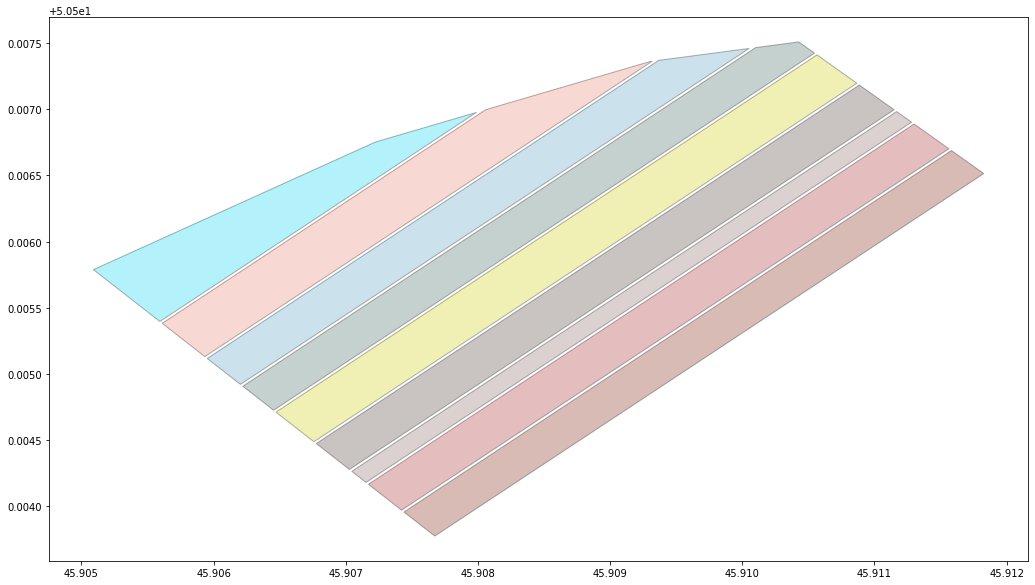

In [ ]:
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from random import randint

fig = plt.figure(figsize=(20,10))
ax = fig.gca() 

patches = []
for poly in wgs_polys:
  if not poly.is_empty:
    color = '#%06X' % randint(0, 0xFFFFFF)
    ax.add_patch(PolygonPatch(poly, fc=color, ec='#000000', alpha=0.3, zorder=2 ))
ax.axis('scaled')
plt.show()